### This is an exploration notebook on LSTM model. The dataset, code for data processing, training and prediction is based on Jason Browniee's [tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)  "Multivariate Time Series Forecasting with LSTMs in Keras"

In [18]:
from __future__ import print_function
import sys, time
from math import sqrt
import numpy as np
from numpy import concatenate
import matplotlib as plt
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn import preprocessing
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import LSTM,Dense,Dropout
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.models import load_model
from keras.utils import plot_model

import json


In [73]:
# # load data
# def parse(x):
#     return datetime.strptime(x, '%Y %m %d %H')

# dataset = read_csv('~/Documents/TTU_study/Fall2019/my_research/neural_network/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
# dataset.drop('No', axis=1, inplace=True)
# # manually specify column names
# dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# dataset.index.name = 'date'
# # mark all NA values with 0
# dataset['pollution'].fillna(0, inplace=True)
# # drop the first 24 hours
# dataset = dataset[24:]
# # summarize first 5 rows
# print(dataset.head(5))
# save to file
# dataset.to_csv('pollution.csv')

## Load and prepare data for training

In [74]:
# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [75]:
dataset.shape

(43800, 8)

In [76]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [77]:
values = dataset.values
print(values)

[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]


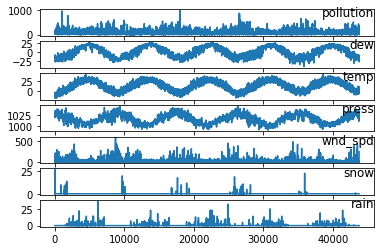

In [78]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [79]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequenceå (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg 

# load dataset
dataset = read_csv('data/pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [80]:
reframed.shape

(43799, 9)

## Split train and test sets

In [81]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [20]:
class CollectWeightCallback(Callback):
    def __init__(self, layer_index):
        super(CollectWeightCallback, self).__init__()
        self.layer_index = layer_index
        self.weights = []

    def on_epoch_end(self, epoch, logs=None):
        layer = self.model.layers[self.layer_index]
        self.weights.append(layer.get_weights())

## Train model

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0603 - val_loss: 0.0588
Epoch 2/50
 - 1s - loss: 0.0384 - val_loss: 0.0664
Epoch 3/50
 - 1s - loss: 0.0199 - val_loss: 0.0351
Epoch 4/50
 - 1s - loss: 0.0166 - val_loss: 0.0228
Epoch 5/50
 - 1s - loss: 0.0159 - val_loss: 0.0179
Epoch 6/50
 - 1s - loss: 0.0156 - val_loss: 0.0158
Epoch 7/50
 - 1s - loss: 0.0153 - val_loss: 0.0147
Epoch 8/50
 - 1s - loss: 0.0152 - val_loss: 0.0142
Epoch 9/50
 - 1s - loss: 0.0150 - val_loss: 0.0139
Epoch 10/50
 - 1s - loss: 0.0149 - val_loss: 0.0137
Epoch 11/50
 - 1s - loss: 0.0150 - val_loss: 0.0137
Epoch 12/50
 - 1s - loss: 0.0149 - val_loss: 0.0136
Epoch 13/50
 - 1s - loss: 0.0148 - val_loss: 0.0135
Epoch 14/50
 - 2s - loss: 0.0148 - val_loss: 0.0135
Epoch 15/50
 - 1s - loss: 0.0148 - val_loss: 0.0135
Epoch 16/50
 - 1s - loss: 0.0148 - val_loss: 0.0136
Epoch 17/50
 - 1s - loss: 0.0148 - val_loss: 0.0135
Epoch 18/50
 - 1s - loss: 0.0148 - val_loss: 0.0136
Epoch 19/50
 - 1s - loss

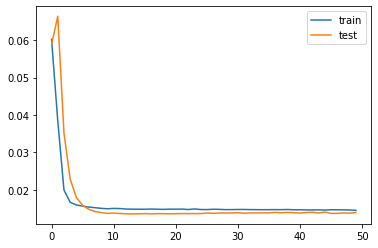

In [82]:
# design network
model = Sequential()
# First LSTM layer
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), name='LSTM1'))
# model.add(Dense(1))
model.add(LSTM(units=50, input_shape=(train_X.shape[1], train_X.shape[2]),name='LSTM2'))
# model.add(Dropout(0.2, name='dropout1'))
# # Second LSTM layer
# model.add(LSTM(units=50, return_sequences=True,name='LSTM2'))
# model.add(Dropout(0.2, name='dropout2'))
# # # Third LSTM layer
# model.add(LSTM(units=50,name='LSTM3'))
# model.add(Dropout(0.2, name='dropout3'))
# # # Fourth LSTM layer
# model.add(LSTM(units=50, name='LSTM4'))
# model.add(Dropout(0.2, name='dropout4'))
# # The output layer
model.add(Dense(units=1, name='output'))
model.compile(loss='mae', optimizer='adam')
start = time.time()

# fit network

cbk = CollectWeightCallback(layer_index=-1)
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False,
#                    callbacks=[cbk])
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False,
                   callbacks=[ModelCheckpoint(filepath='weights{epoch:03d}.hdf5')])




end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [83]:
test_X.shape

(35039, 1, 8)

## Evaluate Model and save model to file

In [87]:
# make a prediction
yhat = model.predict(test_X)
print(yhat)
yhat.shape

[[0.03588513]
 [0.03196473]
 [0.02161688]
 ...
 [0.00929654]
 [0.00925644]
 [0.00763189]]


(35039, 1)

In [88]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.951


In [ ]:
# save model to file
model.save('data/lstm_model.h5')
del model

In [2]:
# load model from file
model = load_model('data/lstm_model.h5')

## Extract Weights from each layer

In [3]:
# show number of layers in total
model.layers

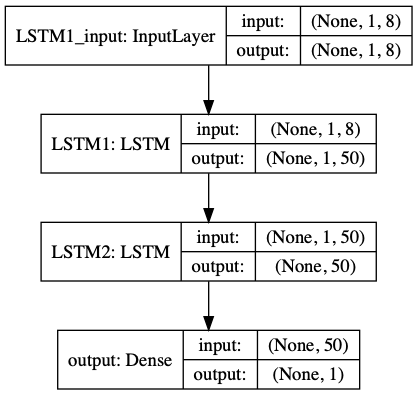

In [4]:
# show model structure and save to file
plot_model(model, to_file='img/model.png', show_shapes=True, show_layer_names=True)

In [5]:
# model.save_weights('data/lstm_weights.h5')

In [27]:
def get_LSTM_UWb(weight):
    '''
    weight must be output of LSTM's layer.get_weights()
    W: weights for input
    U: weights for hidden states
    b: bias
    '''
    warr,uarr, barr = weight
    gates = ["i","f","c","o"]
    hunit = uarr.shape[0]
    U, W, b = {},{},{}
    for i1,i2 in enumerate(range(0,len(barr),hunit)):
        
        W[gates[i1]] = warr[:,i2:i2+hunit]
        U[gates[i1]] = uarr[:,i2:i2+hunit]
        b[gates[i1]] = barr[i2:i2+hunit].reshape(hunit,1)
    return(W,U,b)

# def get_LSTMweights(model1):
#     for layer in model1.layers:
#         if "LSTM" in str(layer):
#             w = layer.get_weights()
#             W,U,b = get_LSTM_UWb(w)
#             break
#     return W,U,b

def get_LSTMweights(model,layer):
    '''
    Get weights for one layer
    '''
    if "LSTM" in str(layer):
        w = layer.get_weights()
        W,U,b = get_LSTM_UWb(w)
    return W, U, b

def vectorize_with_labels(W,U,b):
    bs,bs_label,ws,ws_label,us,us_label=[],[],[],[],[],[]
    for k in ["i","f","c","o"]:
        temp = list(W[k].flatten())
        ws_label.extend(["W_"+k]*len(temp))
        ws.extend(temp)

        temp = list(U[k].flatten())
        us_label.extend(["U_"+k]*len(temp))
        us.extend(temp)    

        temp = list(b[k].flatten())
        bs_label.extend(["b_"+k]*len(temp))
        bs.extend(temp)  
    weight = ws + us + bs
    wlabel = ws_label + us_label + bs_label
    return(weight,wlabel)

In [7]:
# input weights, weights from previous layer and bias weights in the first layer
w1, u1, b1 = get_LSTMweights(model, model.layers[0])

In [8]:
print(w1, u1, b1)

{'i': array([[-5.18189222e-02,  2.81944543e-01,  9.66801047e-02,
         2.09902465e-01,  1.24584764e-01, -2.48225465e-01,
         1.60872698e-01,  2.50937670e-01, -1.54894039e-01,
        -4.96075481e-01,  2.90301982e-02,  1.97872758e-01,
         1.57053694e-01,  2.81879187e-01, -3.33018675e-02,
         1.40239790e-01,  4.47271802e-02,  1.56965777e-02,
         1.93020523e-01,  2.61494875e-01,  3.08222026e-01,
        -1.84827611e-01,  5.96865267e-02,  1.98970437e-01,
         9.01714638e-02, -1.53456643e-01,  1.96757898e-01,
         4.90890481e-02,  2.54736803e-02, -3.60550553e-01,
         7.56893754e-02, -2.04718828e-01,  2.17067912e-01,
         3.06952417e-01,  5.26334308e-02, -2.78127223e-01,
        -2.55765945e-01,  1.84317321e-01,  1.32286444e-01,
         1.27834287e-02, -2.27993820e-02,  1.97600320e-01,
        -6.14436626e-01,  1.76285237e-01,  2.39550680e-01,
         1.74375519e-01,  1.44276932e-01, -2.08849028e-01,
         3.12287927e-01, -1.91190001e-02],
       

In [9]:
# input weights, weights from previous layer and bias weights in the first layer
w2, u2, b2 = get_LSTMweights(model, model.layers[1]) 

In [10]:
print(w2, u2, b2)

{'i': array([[-0.02777169,  0.14399469, -0.13860804, ...,  0.11600811,
        -0.08854572, -0.13604762],
       [-0.11767561,  0.11132465,  0.14484237, ..., -0.06485341,
        -0.00165903, -0.11978483],
       [-0.19134231, -0.1000669 ,  0.15244843, ...,  0.01003725,
        -0.00785018, -0.01689745],
       ...,
       [ 0.05482803, -0.05015094,  0.17597818, ..., -0.01209187,
         0.09383105, -0.06471713],
       [ 0.07736657,  0.06557464,  0.06217273, ...,  0.08750917,
         0.13344853, -0.06929116],
       [-0.02264272,  0.07754299, -0.16949546, ..., -0.12420691,
        -0.15196308, -0.16093655]], dtype=float32), 'f': array([[ 0.08203246, -0.01399004,  0.12220956, ...,  0.05431823,
         0.10377993, -0.05638012],
       [ 0.09468782,  0.04552375, -0.14866813, ...,  0.03467748,
         0.06307054,  0.11238469],
       [ 0.04402475,  0.14000617, -0.03950282, ..., -0.00965017,
         0.1303901 ,  0.02493604],
       ...,
       [-0.12690435,  0.04849692, -0.09329949, .

In [11]:
w1.keys()

dict_keys(['i', 'f', 'c', 'o'])

In [12]:
w2.keys()

dict_keys(['i', 'f', 'c', 'o'])

In [13]:
w1['i'].shape, u1['i'].shape, b1['i'].shape

((8, 50), (50, 50), (50, 1))

In [14]:
w2['i'].shape, u2['i'].shape, b2['i'].shape

((50, 50), (50, 50), (50, 1))

In [15]:
w1['i'].min(), w1['i'].max()

(-0.7308838, 0.31228793)

In [16]:
# w12_i = w1['i'][0].append(w2[i][0])
w1['i'][0]

array([-0.05181892,  0.28194454,  0.0966801 ,  0.20990247,  0.12458476,
       -0.24822547,  0.1608727 ,  0.25093767, -0.15489404, -0.49607548,
        0.0290302 ,  0.19787276,  0.1570537 ,  0.2818792 , -0.03330187,
        0.14023979,  0.04472718,  0.01569658,  0.19302052,  0.26149487,
        0.30822203, -0.18482761,  0.05968653,  0.19897044,  0.09017146,
       -0.15345664,  0.1967579 ,  0.04908905,  0.02547368, -0.36055055,
        0.07568938, -0.20471883,  0.21706791,  0.30695242,  0.05263343,
       -0.27812722, -0.25576594,  0.18431732,  0.13228644,  0.01278343,
       -0.02279938,  0.19760032, -0.6144366 ,  0.17628524,  0.23955068,
        0.17437552,  0.14427693, -0.20884903,  0.31228793, -0.019119  ],
      dtype=float32)

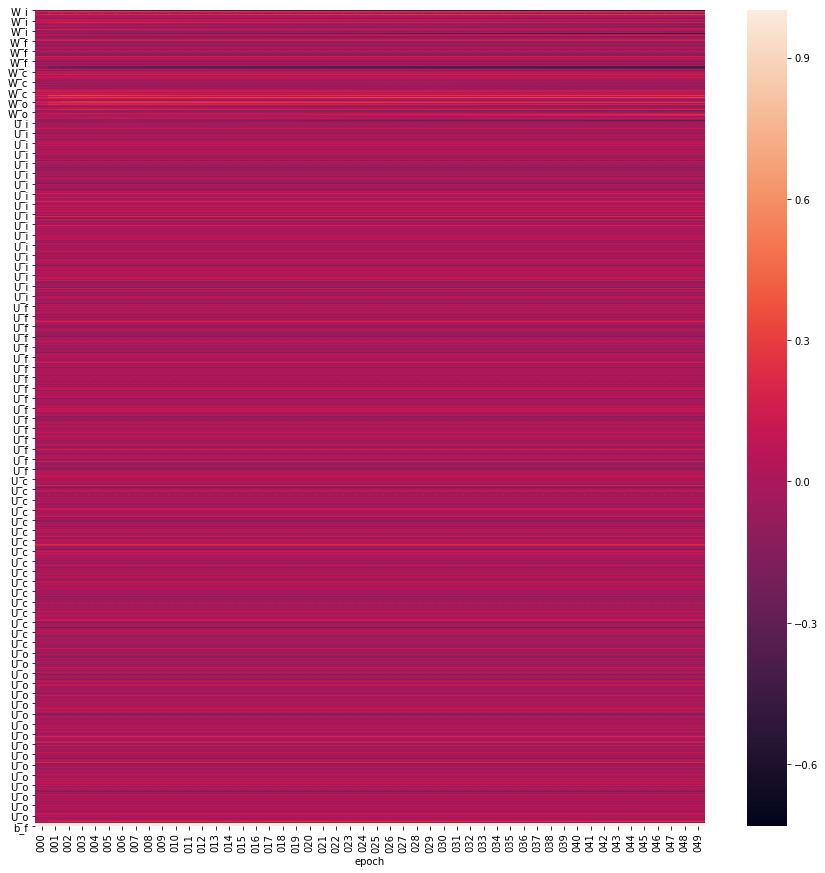

In [29]:
from copy import copy
df = {}
for epoch in np.arange(0,50):
    model.load_weights("weights{:03d}.hdf5".format(epoch+1))
    WUb = get_LSTMweights(model,model.layers[0])
    weight,wlabel = vectorize_with_labels(*WUb)
    df["{:03d}".format(epoch)] = copy(weight)

df = pd.DataFrame(df,index=wlabel)
df = df[np.sort(df.columns)]

pyplot.figure(figsize=(15,15))
sns.heatmap(df)
pyplot.xlabel('epoch')
pyplot.show()

## Plot the weights of input gate, forget gate, cell state and output gate for both LSTM layers

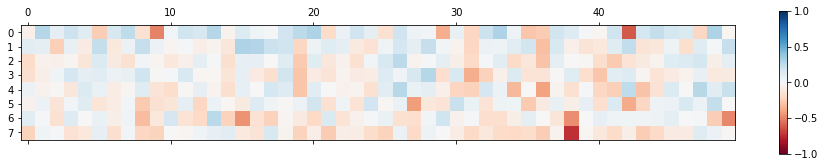

In [17]:
# plot input gate weights for the first layer
pyplot.matshow(w1['i'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

In [169]:
# fig, ax = pyplot.subplots(figsize=(25,5))
# sns.heatmap(w1['i'], vmin=-1, vmax=1,)
# pyplot.show()

In [164]:
# sns.heatmap(w1['i'], vmin=-1, vmax=1, center=0)
# pyplot.show()

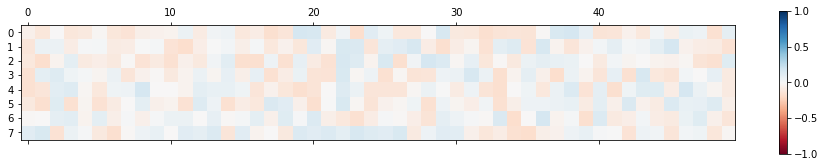

In [165]:
# plot forget gate weights for the first layer

pyplot.matshow(w1['f'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

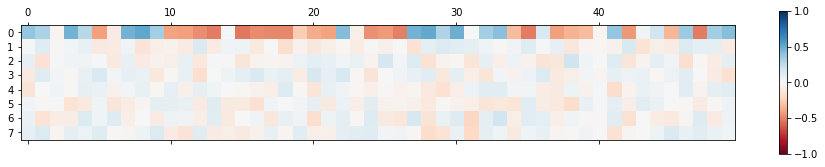

In [196]:
# plot cell state weights for the first layer


pyplot.matshow(w1['c'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

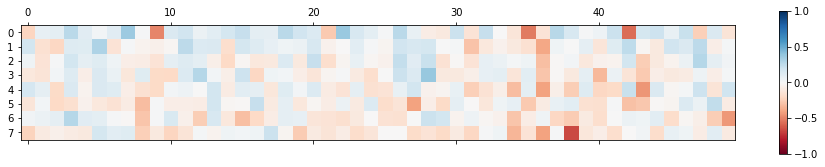

In [146]:
# plot output gate weights for the first layer


pyplot.matshow(w1['o'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

/Users/jaywang/anaconda3/envs/data_science/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


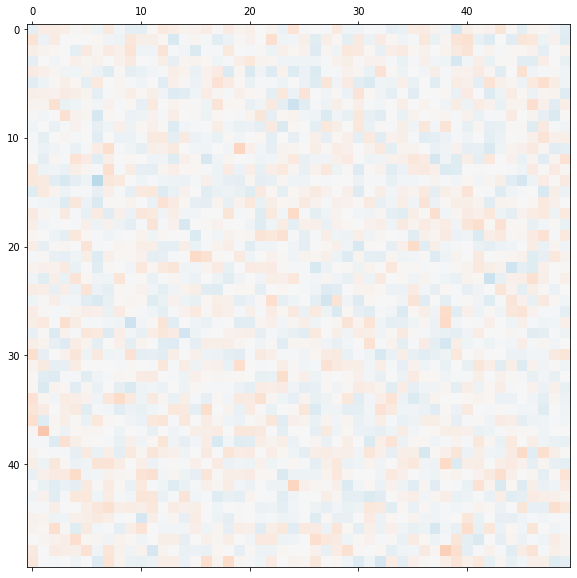

In [182]:
# plot input gate weights for previous hidden states for the first layer


fig, ax = pyplot.subplots(figsize=(10,10))
ax.matshow(u1['i'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
fig.show()

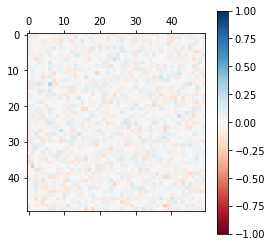

In [184]:
# plot input gate weights for previous hidden states for the first layer


pyplot.matshow(u1['i'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

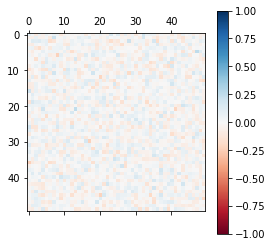

In [183]:
# plot forget gate weights for previous hidden states for the first layer


pyplot.matshow(u1['f'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

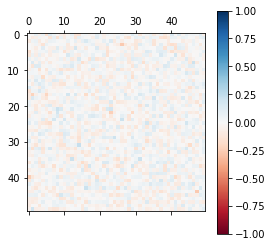

In [185]:
# plot cell state weights for previous hidden states for the first layer


pyplot.matshow(u1['c'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

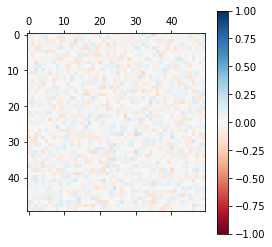

In [186]:
# plot output gate weights for previous hidden states for the first layer


pyplot.matshow(u1['o'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

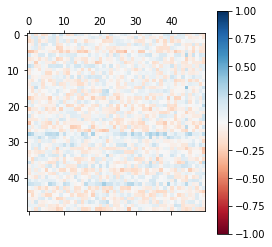

In [187]:
# plot input gate weights for the second layer


pyplot.matshow(w2['i'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

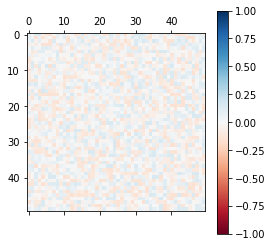

In [188]:
# plot forget gate weights for the second layer

pyplot.matshow(w2['f'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

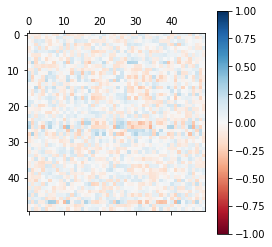

In [189]:
# plot cell state weights for the second layer


pyplot.matshow(w2['c'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

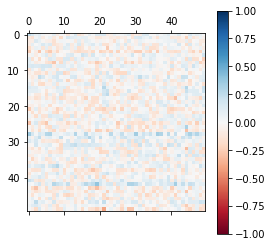

In [191]:
# plot output gate weights for the second layer


pyplot.matshow(w2['o'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

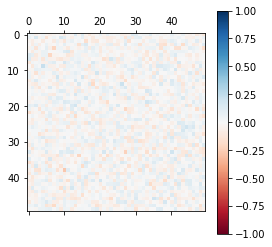

In [192]:

# plot input gate weights for previous hidden states for the second layer

pyplot.matshow(u2['i'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

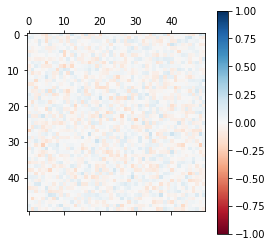

In [193]:
# plot forget gate weights for previous hidden states for the second layer


pyplot.matshow(u2['f'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

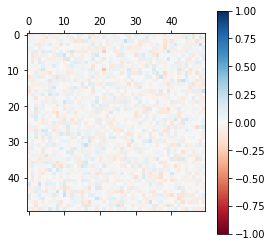

In [194]:
# plot cell state weights for previous hidden states for the second layer

pyplot.matshow(u2['c'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

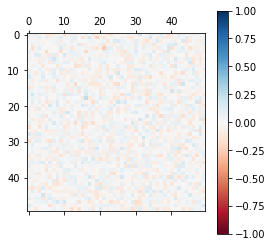

In [195]:
# plot output gate weights for previous hidden states for the second layer


pyplot.matshow(u2['o'], cmap=pyplot.cm.RdBu, vmin=-1, vmax=1)
pyplot.colorbar()
pyplot.show()

### Save each layer's weights to file as json

In [109]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [110]:
def save_to_json(filepath, variable):
    with open('{}.json'.format('filepath')) as f:
        json.dump(variable,f,cls=NumpyEncoder)

In [235]:
with open('data/w1.json', 'w') as f:
    json.dump(w1,f,cls=NumpyEncoder,indent='\t')

In [112]:
with open('data/u1.json', 'w') as f:
    json.dump(u1,f,cls=NumpyEncoder,indent='\t')

In [113]:
with open('data/b1.json', 'w') as f:
    json.dump(b1,f,cls=NumpyEncoder,indent='\t')

In [114]:
with open('data/w2.json', 'w') as f:
    json.dump(w2,f,cls=NumpyEncoder,indent='\t')

In [115]:
with open('data/u2.json', 'w') as f:
    json.dump(u2,f,cls=NumpyEncoder,indent='\t')

In [116]:
with open('data/b2.json', 'w') as f:
    json.dump(b2,f,cls=NumpyEncoder,indent='\t')

In [117]:
# W_i = warr[:, :units]
# W_f = warr[:, units: units * 2]
# W_c = warr[:, units * 2: units * 3]
# W_o = warr[:, units * 3:]

# U_i = uarr[:, :units]
# U_f = uarr[:, units: units * 2]
# U_c = uarr[:, units * 2: units * 3]
# U_o = uarr[:, units * 3:]

# b_i = barr[:units]
# b_f = barr[units: units * 2]
# b_c = barr[units * 2: units * 3]
# b_o = barr[units * 3:]

In [212]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 1, 50)             11800     
_________________________________________________________________
LSTM2 (LSTM)                 (None, 50)                20200     
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 32,051
Trainable params: 32,051
Non-trainable params: 0
_________________________________________________________________


In [119]:
# model.save('lstm_model.h5')
# del model
# model = load_model('lstm_model.h5')

In [121]:
json_string = model.to_json()

In [122]:
json_string

'{"class_name": "Sequential", "config": {"name": "sequential_3", "layers": [{"class_name": "LSTM", "config": {"name": "LSTM1", "trainable": true, "batch_input_shape": [null, 1, 8], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 50, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 2}}, {"class_name": "LST

## Get the output  of each layer and save to file as json

In [198]:
def get_layer_output(model, n):
    return K.function([model.layers[0].input],[model.layers[n].output])    

In [204]:
layer1_output = get_layer_output(model,0)([train_X])[0]
layer1_output.shape

(8760, 1, 50)

In [209]:
layer1_output

array([[[-0.00646154,  0.01688849,  0.0004684 , ..., -0.02163839,
          0.01502744,  0.01323412]],

       [[-0.00448858,  0.01876708,  0.00032897, ..., -0.02497636,
          0.01706425,  0.01530098]],

       [[-0.00398405,  0.02232326,  0.00019956, ..., -0.02516458,
          0.0193579 ,  0.01402716]],

       ...,

       [[-0.01304013,  0.01349653,  0.0007919 , ...,  0.00498294,
         -0.00905494, -0.02336009]],

       [[-0.01474002,  0.01613213,  0.00074824, ...,  0.00525249,
         -0.00820323, -0.02551293]],

       [[-0.01430037,  0.01586805,  0.00092274, ...,  0.00527427,
         -0.00884851, -0.02575966]]], dtype=float32)

In [205]:
layer2_output = get_layer_output(model,1)([train_X])[0]
layer2_output.shape

(8760, 50)

In [210]:
layer2_output

array([[-1.29269613e-02,  1.47334943e-02, -1.18641714e-02, ...,
        -1.52473226e-02,  8.88782181e-03, -8.33672297e-04],
       [-1.50338933e-02,  1.67952310e-02, -1.40835503e-02, ...,
        -1.71394255e-02,  1.07020233e-02, -9.22695850e-04],
       [-1.70142278e-02,  1.83143076e-02, -1.51581531e-02, ...,
        -1.81724001e-02,  1.16973305e-02, -1.03145302e-03],
       ...,
       [-1.13640609e-03,  8.13163497e-05,  5.38079767e-03, ...,
        -2.74080480e-03, -3.91340302e-03, -1.29294198e-03],
       [-2.09845370e-03,  6.84497587e-04,  5.64225391e-03, ...,
        -2.68397154e-03, -4.27918695e-03, -1.50496536e-03],
       [-1.83835474e-03,  4.38770192e-04,  5.83138689e-03, ...,
        -2.77832779e-03, -4.22937796e-03, -1.47071201e-03]], dtype=float32)

In [208]:
layer3_output = get_layer_output(model,2)([train_X])[0]
layer3_output.shape

(8760, 1)

In [211]:
layer3_output

array([[0.12850945],
       [0.1471792 ],
       [0.15918761],
       ...,
       [0.00207979],
       [0.00277373],
       [0.00227519]], dtype=float32)

In [236]:
with open('data/l1_out.json', 'w') as f:
    json.dump(layer1_output,f,cls=NumpyEncoder,indent='\t')

In [237]:
with open('data/l2_out.json', 'w') as f:
    json.dump(layer2_output,f,cls=NumpyEncoder,indent='\t')

In [238]:
with open('data/l3_out.json', 'w') as f:
    json.dump(layer3_output,f,cls=NumpyEncoder,indent='\t')